In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from PIL import Image, ImageDraw
from IPython import display
import numpy as np
import os

In [2]:
data_dir = 'data/sample2'

batch_size = 32
epochs = 8
workers = 0 if os.name == 'nt' else 8

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [4]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [5]:
dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]
        
loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

frames_tracked = []
for i, (x, y) in enumerate(loader):
    mtcnn(x, save_path=y)
    for img in x:
        boxes, _ = mtcnn.detect(img)

        # Draw faces
        frame_draw = img.copy()
        draw = ImageDraw.Draw(frame_draw)
        for box in boxes:
            draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)

        # Add to frame list
        frames_tracked.append(frame_draw)
    
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
    
# Remove mtcnn to reduce GPU memory usage
del mtcnn

c:\users\mina\anaconda3\envs\koreansentimentanalysis\lib\site-packages\facenet_pytorch\models\utils\detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
c:\users\mina\anaconda3\envs\koreansentimentanalysis\lib\site-packages\facenet_pytorch\models\mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  boxes = np.array(boxes)
c:\users\mina\anaconda3\envs\koreansentimentanalysis\lib\site-packages\facenet_pytorch\models\mtcnn.py:340: VisibleDeprecationWarning: Creat

Batch 1 of 1

In [6]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
).to(device)

In [7]:
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds)
)

In [8]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

In [9]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------
Valid |     1/1    | loss:    1.9079 | fps:    5.1013 | acc:    0.0000   

Epoch 1/8
----------
Train |     1/1    | loss:    1.6317 | fps:   10.7238 | acc:    0.2500   
Valid |     1/1    | loss:    1.8008 | fps:    6.4669 | acc:    0.5000   

Epoch 2/8
----------
Train |     1/1    | loss:    0.2013 | fps:   33.6919 | acc:    1.0000   
Valid |     1/1    | loss:    2.0744 | fps:   71.4143 | acc:    0.0000   

Epoch 3/8
----------
Train |     1/1    | loss:    0.0226 | fps:   37.4268 | acc:    1.0000   
Valid |     1/1    | loss:    2.7593 | fps:   76.9788 | acc:    0.0000   

Epoch 4/8
----------
Train |     1/1    | loss:    0.0054 | fps:   38.1662 | acc:    1.0000   
Valid |     1/1    | loss:    3.7511 | fps:   74.2736 | acc:    0.0000   

Epoch 5/8
----------
Train |     1/1    | loss:    0.0028 | fps:   36.4607 | acc:    1.0000   
Valid |     1/1    | loss:    4.4652 | fps:   74.2723 | acc:    0.0000   

Epoch 6/8
----------
Train |     1/1    | loss:    0.0

In [10]:
print(frames_tracked)

[<PIL.Image.Image image mode=RGB size=512x512 at 0x271020125F8>, <PIL.Image.Image image mode=RGB size=512x512 at 0x27102083828>, <PIL.Image.Image image mode=RGB size=512x512 at 0x271020836A0>, <PIL.Image.Image image mode=RGB size=512x512 at 0x27102089390>, <PIL.Image.Image image mode=RGB size=512x512 at 0x27102089400>, <PIL.Image.Image image mode=RGB size=512x512 at 0x27102089470>]


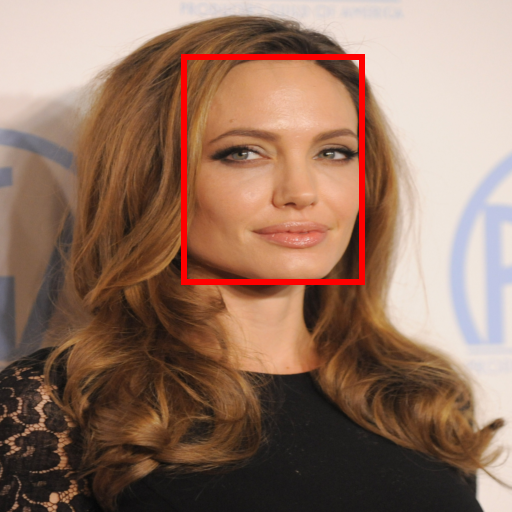

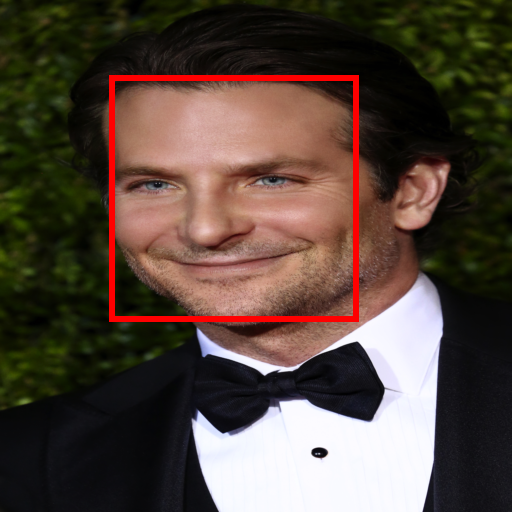

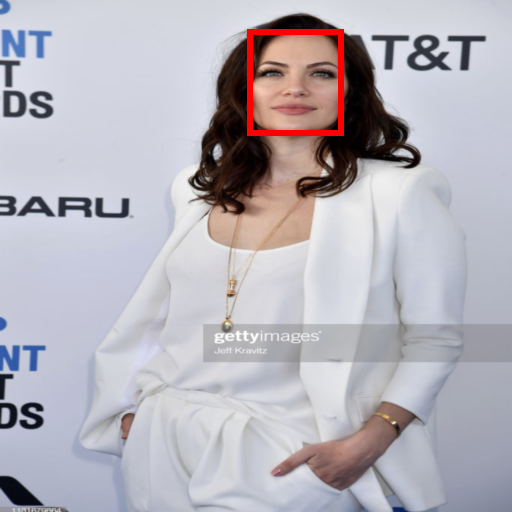

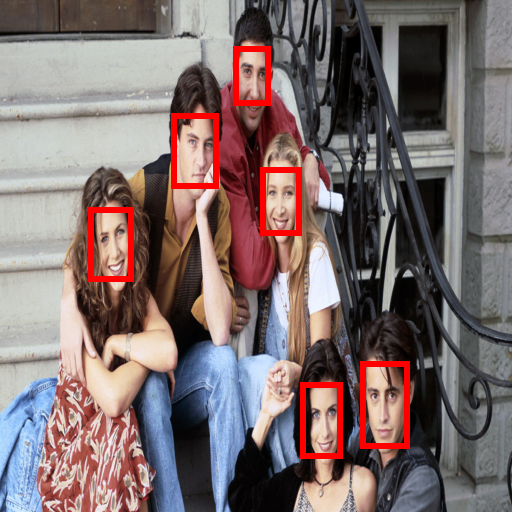

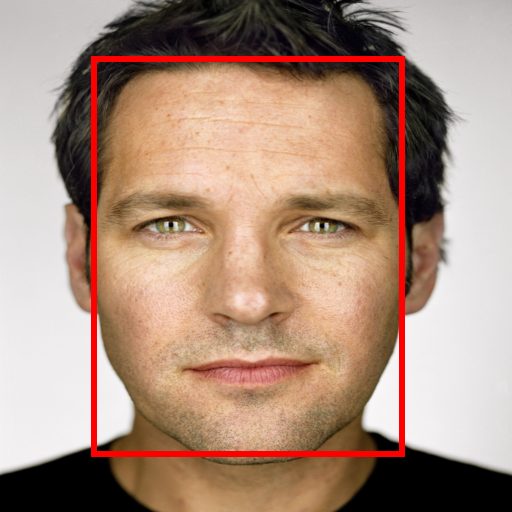

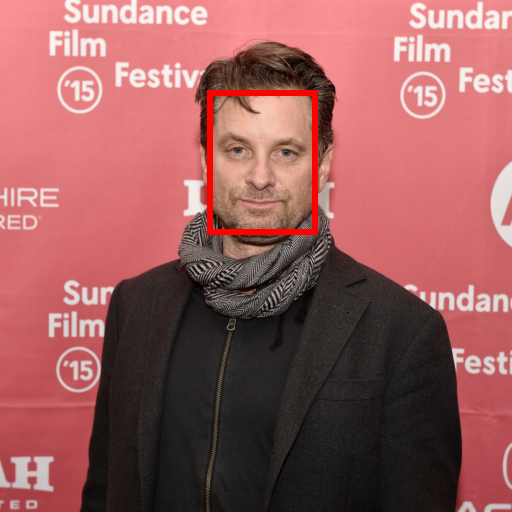

In [11]:
for i, im in enumerate(frames_tracked):
    im.save('data/sample2_result/img{:03}.jpg'.format(i))
    display.display(im)